# Unit 6 - Sesmic Waveform Polarization Analysis
### July 28th 2020

*Lab exercises provided by Tolulope Olugboji and Liam Moser; translated into Python by Fransiska Dannemann Dugick and Suzan van der Lee*


# Exercise I: Arrival Direction of Earthquake (P Polarization)

The figure below  describes how the correct horizontal orientation of a sensor can be deduced from the measured polarization azimuth of an incoming P wave or surface wave __[(Ojo et al. 2019)](https://pubs.geoscienceworld.org/ssa/srl/article-abstract/573314/estimations-of-sensor-misorientation-for-broadband)__.  In their paper, which reviews a variety of standard techniques, the authors describe three ways of inferring the correct orientation.

![Fig 1](img/ojo_fig1.png)

Fig 1: (from Ojo et al., 2019) Orientation of the horizontal seismometer for a left-handed coordinate system on an ideal Earth. BHZ emerges out of the page toward the reader, and the misaligned components are BH1, and  BH2. The angles,  represent the BH1 azimuth, true earthquake azimuth, and measured earthquake azimuth respectively.

__Your objective is to use the technique of minimizing the transverse energy following rotation to the correct radial direction using OSB data.__

First, load in the provided data as text files.

Then, use the equation below to infer the measured earthquake azimuth in the radial direction. 

$ E_T(\theta)=\frac{\sum_{i=1}^{N} w_i E_i^T (\theta)}{\sum_{i=1}^{N} w_i}$

In this case since we have only one earthquake, $i=1=N$ and $w_i=1$. Also the true earthquake azimuth is $280^\circ$ and $E_T$ should be the length of the transverse direction in the time window 2.5 minute to 4.0 minute. The data is sampled at 50 Hz.

In [1]:
# import the usual modules
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]

In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# yep, we're using ObsPy
from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime

3 Trace(s) in Stream:
RS.SAMPLE..BHZ | 1999-01-01T00:00:00.000000Z - 1999-01-01T01:02:59.980000Z | 50.0 Hz, 189000 samples
RS.SAMPLE..BH1 | 1999-01-01T00:00:00.000000Z - 1999-01-01T01:02:59.980000Z | 50.0 Hz, 189000 samples
RS.SAMPLE..BH2 | 1999-01-01T00:00:00.000000Z - 1999-01-01T01:02:59.980000Z | 50.0 Hz, 189000 samples


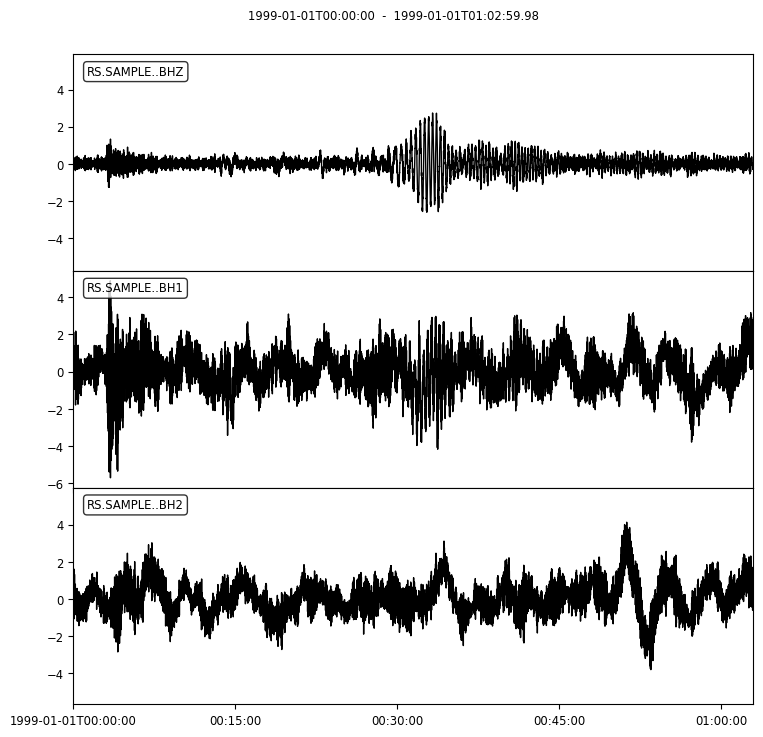

In [3]:
# arbitrary scale factor and begin time:
scale = 1/10000
begin = UTCDateTime('1999-01-01T00:00:00')

# read in seismic waveform data from text files:
datZ = scale*np.array(np.loadtxt('sample_BHZ_long.txt'))
dat1 = scale*np.array(np.loadtxt('sample_BH1_long.txt'))
dat2 = scale*np.array(np.loadtxt('sample_BH2_long.txt'))

# create common header values ...
head = Stats() 
head.network = 'RS'; head.station = 'SAMPLE'
head.sampling_rate = 50; head.starttime = begin

#... and channel-specific header values and create Trace objects
head.channel = 'BHZ'; head.component = 'Z'; head.npts = len(datZ)
trZ = Trace(data=datZ,header=head)
head.channel = 'BH1'; head.component = '1'; head.npts = len(dat1)
tr1 = Trace(data=dat1,header=head)
head.channel = 'BH2'; head.component = '2'; head.npts = len(dat2)
tr2 = Trace(data=dat2,header=head)

# create data Stream object from Trace objects:
st = Stream(traces=[trZ,tr1,tr2])
print(st)
st.plot();


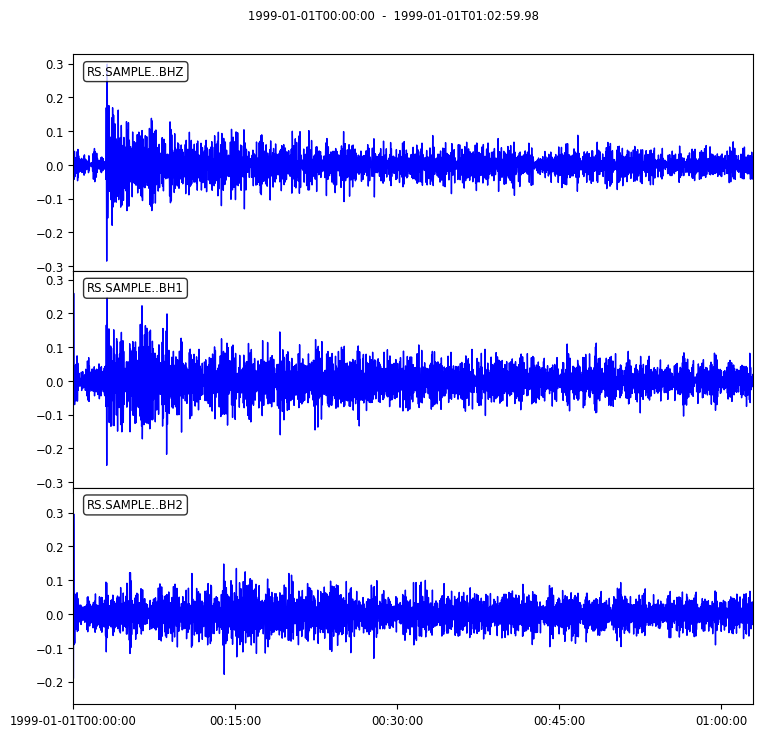

In [4]:
# Bandpass waveforms to highlight P-wave energy. 
# Remember to keep original data stream intact.
stf = st.copy()
stf.filter('bandpass',freqmin=0.1, freqmax=0.3,corners=4, zerophase=True)
stf.plot(color='b');

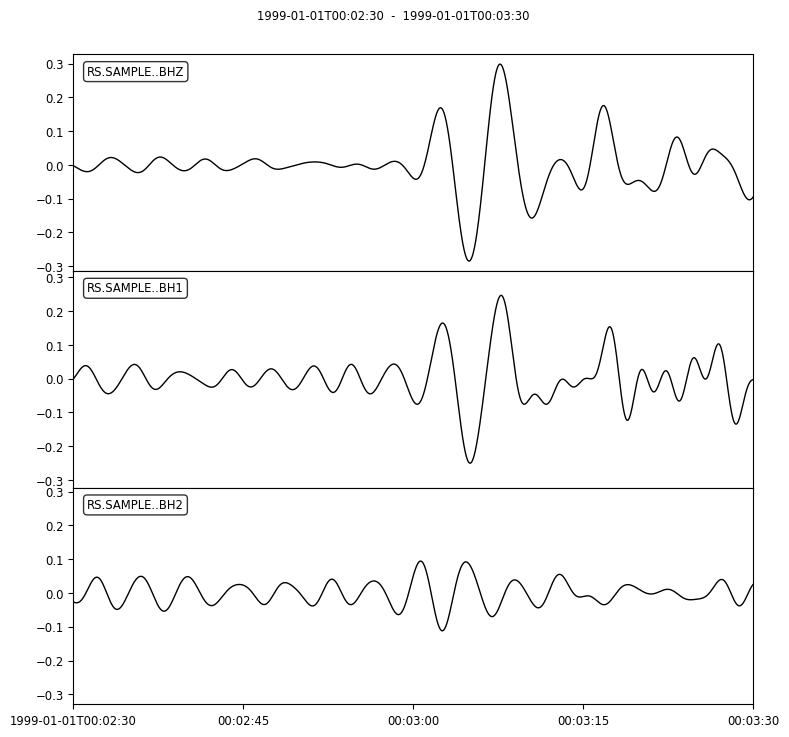

In [5]:
# Select time window around P-wave arrival.
stP = stf.slice(starttime=begin+2.5*60,endtime=begin+3.5*60)
stP.plot();

1. Do you see the P wave on the vertical channel?
2. Which of the two horizontal components has a weaker P-wave signal and what might that mean?
3. Might the two components already oriented in the Radial and Transverse directions for this particular earthquake? How can you investigate?

Rotate BH1 and BH2 components to find the rotation angle in `alpha` that miminizes P-wave energy on one of the two channels. 

In [6]:
def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

In [7]:
c1 = np.ones(3)
c2 = np.zeros(3)
o1,o2 = rotate(c1,c2,330)
print(o1)
print(o2)

[ 0.8660254  0.8660254  0.8660254]
[-0.5 -0.5 -0.5]


In [8]:
# re-extract waveform arrays from the data stream for two horizontal channels:
hh2 = stP[2].data
hh1 = stP[1].data

tvall = []
alpha = np.arange(0,360,5)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
for a in alpha:
    hhT,hhR = rotate(hh2,hh1,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)

tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)


optimal angle =  165  or  -15


Text(167, 10, '$\\theta_t$ = 165$\\degree$')

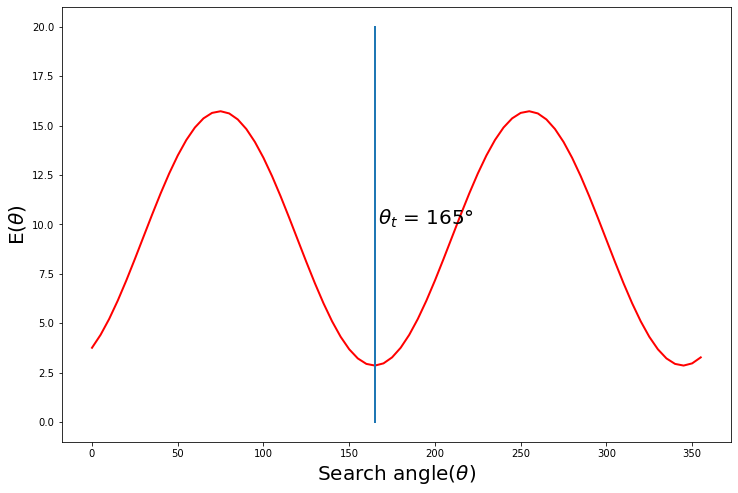

In [9]:
# plot T energy vs. rotation angle:
plt.plot(alpha, tval, 'r-', linewidth=2)
plt.xlabel('Search angle'+r'($\theta$)', fontsize=20)
plt.ylabel(r'E($\theta$)', fontsize = 20)

# Add a vertical line at the point of minimum energy
plt.plot([mina,mina],[0,20],linewidth = 2)
plt.text(mina+2,10,r'$\theta_t$ = '+ thetat +r'$\degree$', fontsize=20)


In [10]:
# we happen to know this earthquake's epicenter, and thus the backazimuth
baz = 280
# calculate azimuth of BH1 channel, following equations outlined above
# Add 180 bc Radial direction points away from earthquake
H1ang = baz + 180 - mina
print('Azimuth of H1 = ',H1ang)


Azimuth of H1 =  295


Now we're done. 
1. How does your azimuth for BH1 compare to others'?
2. How might you improve the precision of your estimate?

Lastly, it might be interesting to rotate the BH1 and BH2 channels to the BHR and BHT channels, given our new knowledge of channel orientation and the backazimuth to the earthquake:

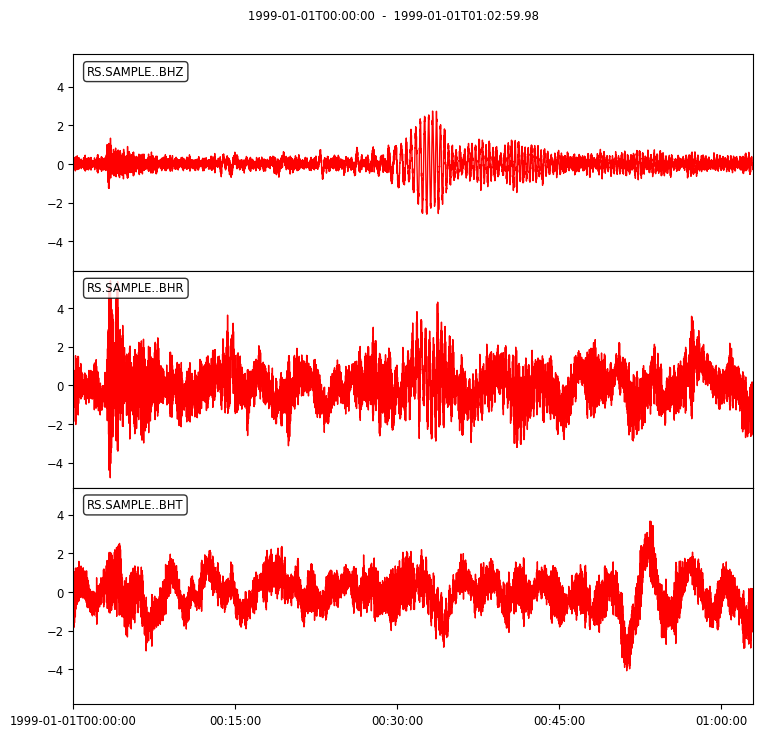

In [11]:
# Rotate horizontal channels over the optimal angle (that minimizes P wave energy on T channel)
trTa,trRa = rotate(st[2].data,st[1].data,mina)

# create new Strem object:
head.channel = 'BHR'; head.component = 'R'; head.npts = len(trRa)
head.azimuth = baz-180; head.dip = 0.
trR = Trace(data=trRa,header=head)
head.channel = 'BHT'; head.component = 'T'; head.npts = len(trTa)
head.azimuth = baz-90.; head.dip = 0.
trT = Trace(data=trTa,header=head)

stafter = Stream(traces=[st[0],trR,trT])
stafter.plot(color='r');

### Challenge:

Do the same for station ANMO using the recent earthquake in Alaska. More precisely:
1. Use ObsPy to download a data stream of 3-component data from this earthquake, as recorded by the BH channels of ANMO.00, which is a Streckeisen STS-6A VBB Seismometer.
2. Select a time window/slice/trim around the direct P-wave arrival.
3. Find the optimal rotation angle that minimizes the energy in this window on the T (transverse) component trace. 
4. Report the angle, and plot results at various stages.
5. Use the known backazimuth to the earthquake to calculate the orientation of the BH1 and BH2 components, and report them here or on Slack. 

Relevant info:
1. The M7.8 earthquake in Alaska occurred at 2020-07-22T06:12:44 
2. The backazimuth at ANMO to this earthquake's epicenter is 316 degrees, which makes the "earthquake azimuth" 136 degrees (azimuth of the radial component).

Report results on the ROSES Slack channel for unit 6. 

In [12]:
#enter Challenge code here




# Exercise II: Near Surface Velocity  (P & S Polarization)

The figure below is taken from __[(Rondenay, 2009)](https://link.springer.com/article/10.1007/s10712-009-9071-5)__ and __[(Reading et al., 2003)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003GL018090)__ and demonstrates coordinate transformations from the cartesian frame (ZRT) into two reference frames (i.e., LQT and PSH) that attempt to separate longitudinal and transverse seismic waves.

![Fig 2](img/fig2.png)

__Using the transformation matrices below, and following from the general rotation and transformation matrices can you confirm the shear and compressional velocities have been fully separated used to generate the synthetic waveform Rondenay2019_syntrace.txt?__ 

![Fig 3](img/ex2_eq.png)

The synthetic waveforms are constructed using the RAYSUM package __[(Frederiksen and Bostock 2000)](https://academic.oup.com/gji/article/141/2/401/648238)__ for an incident P-wave with backazimuth $\gamma =30^\circ$ and a ray parameter $p=0.08 s/km$, recorded at a single surface location. The model sampled by the incident wave is isotropic, and consists of a 40 km-thick horizontal layer $(\alpha_0=6.0 km/s, \beta_0 = 3.4 km/s, \rho_0 = 2,600 kg/m^3)$ over a half-space $(\alpha_1 = 8.1 km/s, \beta_1 = 4.5 km/s, \rho_1 = 3,500 kg/m^3)$

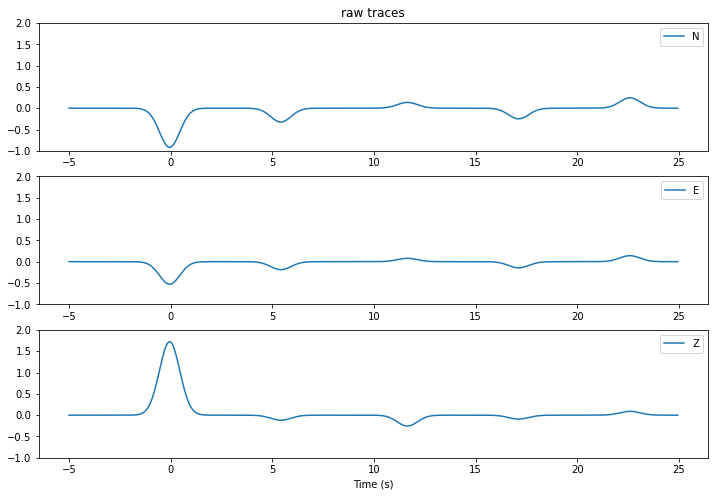

In [13]:
# read in synthetic data:
syntrace = np.loadtxt('Rondenay2019_syntrace.txt',unpack=True) # N E Z - Time
traces = syntrace[:3]
# x axis vector with sampling times:
tvec = syntrace[3]

# always look at your data, even if synthetic:
plt.subplot(311)
plt.plot(tvec,traces[0],label='N')
plt.ylim([-1,2])
plt.title('raw traces')
plt.legend()
plt.subplot(312)
plt.plot(tvec,traces[1],label='E')
plt.ylim([-1,2])
plt.legend()
plt.subplot(313)
plt.plot(tvec,traces[2],label='Z')
plt.ylim([-1,2]);
plt.legend()
plt.xlabel('Time (s)');

What do you see?
1. The wavelet at 0 s is a P wave. Is its polarization consistent with the reported backazimuth? Why?
2. Are the amplitudes of the P waves consistent with the reported backazimuth? Why?
3. What do you notice about the polarizations of other wavelets? What might that mean?

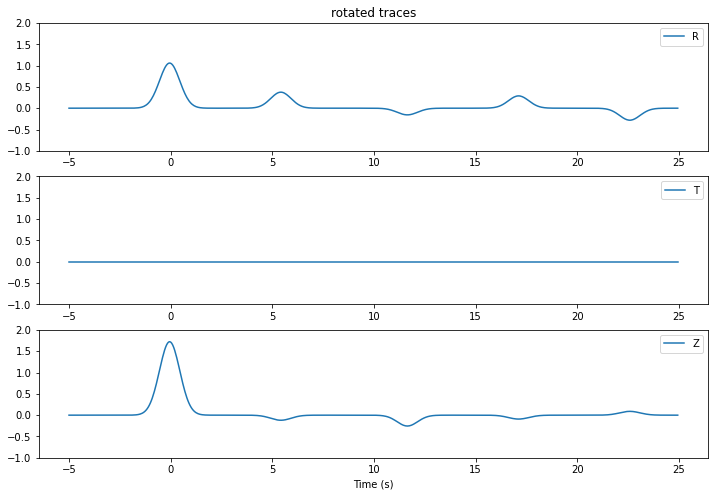

In [14]:
# Rotate from E & N to T and R components
# Given the backazimuth, the Radial component azimuth is 180 degrees away from it
abaz = 210
trT,trR = rotate(traces[1],traces[0],abaz)
trZ = traces[2]

# visualize the result
plt.subplot(311)
plt.plot(tvec,trR,label='R')
plt.ylim([-1,2]); plt.legend(); plt.title('rotated traces')
plt.subplot(312)
plt.plot(tvec,trT,label='T')
plt.ylim([-1,2]); plt.legend()
plt.subplot(313)
plt.plot(tvec,trZ,label='Z')
plt.ylim([-1,2]); plt.legend(); plt.xlabel('Time (s)');

What happened? Did you expect this?

Text(0.5, 0, 'Time (s)')

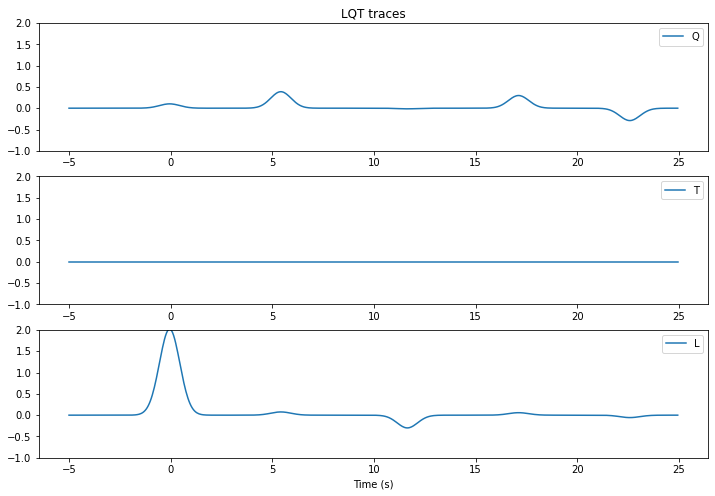

In [15]:
# Rotate from R & Z to Q & L components
alpha = 6.0  # P-velocity
rayp = 0.08  # ray parameter
a = np.degrees(np.arcsin(rayp*alpha)) # incidence angle of P wave:
trQ,trL = rotate(trR,trZ,a)

# plot result
plt.subplot(311)
plt.plot(tvec,trQ,label='Q')
plt.ylim([-1,2]); plt.legend(); plt.title('LQT traces')
plt.subplot(312)
plt.plot(tvec,trT,label='T')
plt.ylim([-1,2]); plt.legend()
plt.subplot(313)
plt.plot(tvec,trL,label='L')
plt.ylim([-1,2]); plt.legend(); plt.xlabel('Time (s)')

What happened? Did you expect this?

Text(0.5, 0, 'Time (s)')

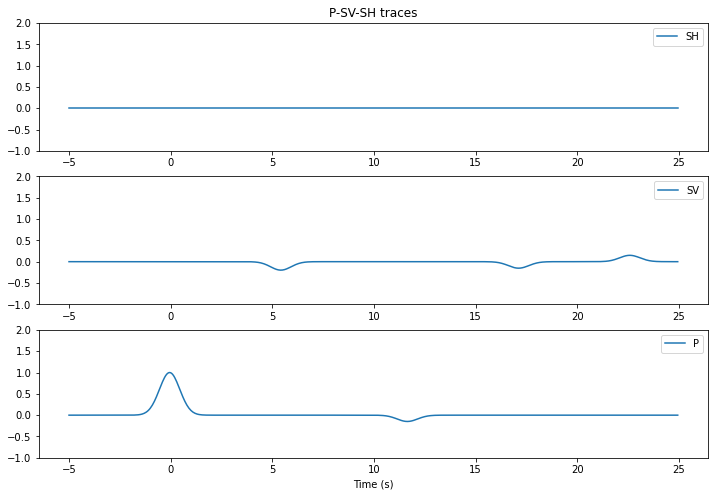

In [16]:
# rotate from LQT to P-SV-SH using a rotation matrix 
beta = 3.4   # S-velocity
q_a  = np.sqrt(alpha**(-2.0) - rayp**2)  # vertical P slowness
q_b  = np.sqrt( beta**(-2.0) - rayp**2)  # vertical S slowness

# create rotation matrix as described above
m11 = (1 - 2*beta**2*rayp**2)/(2*alpha*q_a)
m12= (rayp*beta**2)/(alpha)
m21 = (beta*rayp) 
m22= (2*rayp**2*beta**2  - 1)/(2*beta*q_b)
ROTM = np.array([[m11,m12,0. ],
                 [m21,m22,0  ],
                 [  0,  0,0.5]])

# Gather channels in a 3xn array and rotate
trZRT = np.array([trZ,trR,trT])
trPVH = np.dot(ROTM,trZRT)

# plot results
plt.subplot(311)
plt.plot(tvec,trPVH[2],label='SH')
plt.ylim([-1,2]); plt.legend(); plt.title('P-SV-SH traces')
plt.subplot(312)
plt.plot(tvec,trPVH[1],label='SV')
plt.ylim([-1,2]);plt.legend()
plt.subplot(313)
plt.plot(tvec,trPVH[0],label='P')
plt.ylim([-1,2]); plt.legend()
plt.xlabel('Time (s)')


Now you're done. What happened? Did you expect this?

### Challenge
Apply this technique on an actual observed long-period (LH?) seismogram, for example from the recent M7.8 earthquake in Alaska.


# Exercise III Anisotropy & Shear Wave Splitting (@Shearer3rdEd)


The figure below plots an SKS arrival recorded at the Canadian station ILON for a 2006/8/25 earthquake at 94o epicentral distance and at an azimuth (clockwise from north) of 166o (at ILON to the quake). Seismograms for the east and north components (20 samples/s): ILON_data.txt (data courtesy Ian Bastow, see also Darbyshire et al., 2013).

![Fig 3](img/ex3_ex.png)

__Read in the data and produce your own version of the plots below__

In [17]:
# read in data from file, subtract the mean, set time axis array
dat = np.loadtxt('ILON_data.txt',skiprows=4,unpack=True) # time E N 
tvec = dat[0]
#nLen = len(tvec) 
deltaT = tvec[1] - tvec[0]
trE = dat[1] - np.mean(dat[1])
trN = dat[2] - np.mean(dat[2])
traces = np.array([trE,trN])

Text(0.5, 1.0, 'Particle Motion')

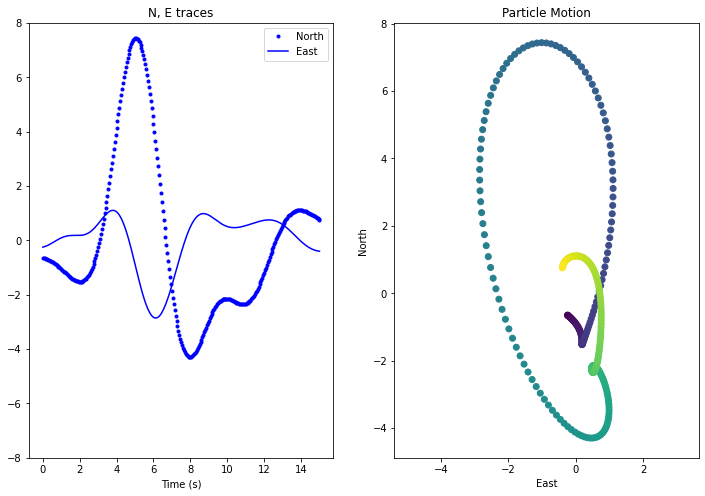

In [18]:
# Always look at your data
plt.subplot(121)
plt.plot(tvec,traces[1],'b.',label='North')
plt.plot(tvec,traces[0],'b-',label='East')
plt.ylim([-8,8]); plt.legend(); plt.xlabel('Time (s)')
plt.title('N, E traces')
plt.subplot(122)
plt.scatter(traces[0],traces[1],c=tvec)
plt.ylim([-8,8]); plt.xlim([-8,8]); plt.xlabel('East'); plt.ylabel('North')
plt.axis('equal'); plt.title('Particle Motion')

1. Given the backazimuth of this earthquake, do you expect the N and E waveforms to look like they do?
2. Do the plots look like the ones from Shearer/Bastow/Darbyshire above?
3. In the absence of anisotropy (and heterogeneity) what would the particle motion plot have looked like for this SKS wave?

Using the covariance matrix method for shear-wave splitting analysis, solve for the fast-axis orientation,$\phi$ ,and delay time,$\delta t$, tha yields the maximum eigenvalue ratio $\lambda_1 / \lambda_2$ . What are $\phi$, and $\delta t$? What is the azimuth of the eigenvector associated with the largest eigenvalue and how does it compare to the radial direction?

In [19]:
# define a grid of possible rotation angles and delay times for separately propagating fast and slow waves
phi = alpha = np.arange(0,360,1); nphi = len(phi)
#dt = np.arange(-30*deltaT,30*deltaT,deltaT); ndt = len(dt)
dt = np.arange(0,30*deltaT,deltaT); ndt = len(dt)

phig, dtg = np.meshgrid(phi,dt)
minsurf = np.zeros(np.shape(phig))

In [20]:
from numpy.linalg import eig

# search for possible axis rotations and delay times that maximally separate the fast and slow SV waves
maxval = 0
for i in np.arange(ndt):
    t = dt[i]
    for j in np.arange(nphi):
        p = np.radians(phi[j]); nshift = int(t/deltaT)
        # rotation matrix consistent with rotate() convention from above: 
        ROTM = np.array([[np.cos(p), -np.sin(p)],
                         [np.sin(p),  np.cos(p)]])
        rotes = np.dot(ROTM,traces)
        # Assume that rotes[0] is Slow axis and rotes[1] is Fast
        # delay the Fast axis to align it with the Slow one
        rotes[1] = np.roll(rotes[1],nshift)
        C = np.dot(rotes,rotes.T)
        D, V = eig(C)
        val = np.max(D)/np.min(D)
        if val > maxval:
            maxval = val
            imax = i; jmax = j
            polarity = np.sign(C[0,1])
        minsurf[i,j] = val

phimax = phig[imax,jmax]; dtmax = dtg[imax,jmax]
print(maxval)
print("best angle = ",phimax," or ",phimax-180)
print("best delay = ",dtmax)


394.859910582
best angle =  23  or  -157
best delay =  0.7


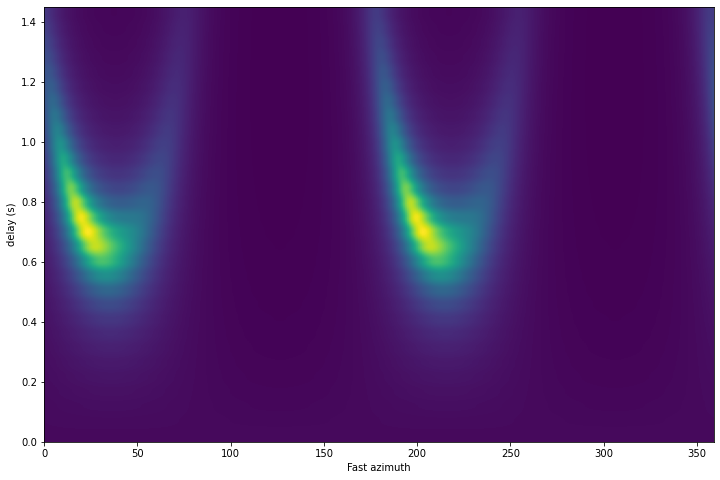

In [21]:
# plot results of eigenvalue ratio over the grid.
plt.imshow(minsurf, aspect='auto', origin='lower', extent=[phi[0],phi[-1],dt[0],dt[-1]])
plt.xlabel('Fast azimuth')
plt.ylabel('delay (s)')
plt.show()

__Using these results, plot the $u_{fast}$ and $u_{slow}$ pulses and the model-corrected participle motion (see example case below)__

![Fig 4](img/ex3_ex1.png)

Text(0.5, 1.0, 'Particle Motion')

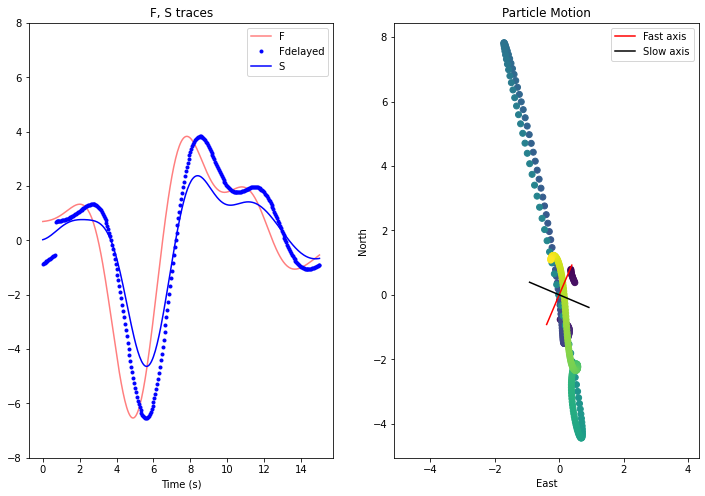

In [22]:
#rotate E-N traces into S-F coordinate system:
p = np.radians(phimax)
ROTM = np.array([[np.cos(p), - np.sin(p)],
                 [np.sin(p),   np.cos(p)]])
rotes = np.dot(ROTM,traces)
trF = polarity*rotes[1]   # save undelayed fast axis for plotting

# Shift by delay time to align Fast axis with Slow for particle motion plot
t = dtmax
nshift = int(t/deltaT)
rotes[1] = np.roll(rotes[1],nshift)

# rotate back into in E-N coordinate system for particle motion plot.
pr = np.radians(-phimax)
ROTM = np.array([[np.cos(pr), - np.sin(pr)],
                 [np.sin(pr),   np.cos(pr)]])
notes = np.dot(ROTM,rotes)

# get coordinates of Slow and Fast Axes in E-N coordinate system, for plotting
xmax = np.sin(p); xmin = -xmax
ymax = np.cos(p); ymin = -ymax


# plot results
plt.subplot(121)
plt.plot(tvec,trF,'r-',label='F',alpha=0.5)  # undelayed Fast axis
plt.plot(tvec,polarity*rotes[1],'b.',label='Fdelayed') # Fast component aligned with Slow one
plt.plot(tvec,rotes[0],'b-',label='S')
plt.ylim([-8,8]); plt.legend(); plt.xlabel('Time (s)')
plt.title('F, S traces')

plt.subplot(122)
plt.scatter(notes[0],notes[1],c=tvec)
plt.plot([xmin,xmax],[ymin,ymax],'r-',label='Fast axis')
plt.plot([ymin,ymax],[-xmin,-xmax],'k-',label='Slow axis')
plt.ylim([-8,8]); plt.xlim([-8,8]); plt.xlabel('East'); plt.ylabel('North')
plt.legend(); plt.axis('equal'); plt.title('Particle Motion')

What do you see? 
1. Is particle motion aligned with the backazimuth from which waves arrive?
2. What would happen if the fast axis was aligned the backazimuth or at right angles to it?
3. Can you think of other ways to obtain the result?
4. Can you replot the figure you plotted above with the imshow() function as a polar plot?

In [23]:
# Use this cell to create a polar plot of minsurf as a function of azimuth and delay time
# Note that instructors did not figure this out :-)





### Challenge
Use a different method to obtain the same or similar results: 

Apply the minimum transverse energy method for shear-wave splitting analysis, solve for the fast-axis orientation, $\phi$, and delay time, $\delta t$, that yields the least transverse energy in the model-corrected motion. What are $\phi$ and delay time $\delta t$ in this case?

Using the results, plot the $u_{fast}$ and $u_{slow}$ pulses and the model-corrected participle motion

What factors might account for the differences between your results for the two methods? Which method do you think is better for this case?

In [24]:
# enter your challenge code here:



